### Sedimentary Log Estimator

This notebook will allow a user to import sedimentary log data and generate a `striplog` from it. 

Image --> `Striplog`

### Import the useful stuff

In [1]:
import numpy as np
import pandas as pd
import lasio
import welly
import striplog
import matplotlib.pyplot as plt
import matplotlib.colors as colors
striplog.__version__

'0.8.9'

In [2]:
from striplog import Striplog, Legend, Lexicon, Interval, Component

In [3]:
legend = Legend.builtin('NSDOE')
lexicon = Lexicon.default()

Import our sedimentary log's discretised from an image

Sort the values with the highest elevation of the log at the top

In [4]:
df = pd.read_csv("cairn_pts_WebPlot.csv", names=['grainsize', 'depth']).round(3)
df = df.sort_values(by='depth', ascending=False)
df.head()

,grainsize,depth
1762,1.845,48.535
1876,2.190,48.535
1622,1.500,48.535
1799,1.960,48.535
1913,2.305,48.535


Looks like our input has negative 'depth' from the ground (this is elevation), this isn't right.

Well need to clean that up

In [5]:
elev_correction = df['depth'].min()
elev_correction

-1.148

Take the elevation difference away from our log and sort by the _new_ elevation to check

In [6]:
df['elevation'] = df['depth'].add(abs(elev_correction))
df

,grainsize,depth,elevation
1762,1.845,48.535,49.683
1876,2.190,48.535,49.683
1622,1.500,48.535,49.683
1799,1.960,48.535,49.683
1913,2.305,48.535,49.683
...,...,...,...
3013,4.643,-1.081,0.067
2958,4.528,-1.081,0.067
3064,4.758,-1.081,0.067
1,-1.145,-1.120,0.028


In [7]:
df = df.drop(columns=['depth'])
df.head()

,grainsize,elevation
1762,1.845,49.683
1876,2.190,49.683
1622,1.500,49.683
1799,1.960,49.683
1913,2.305,49.683


We'll also need to chnage all of the values that have a negative grainsize (that doesn't make sense) to a `'0'` grainsize. This was due to an error in the extraction of the curve

In [8]:
df.loc[df.grainsize < 0, 'grainsize'] = 0
df.sort_values(['elevation'])
df.head()

,grainsize,elevation
1762,1.845,49.683
1876,2.190,49.683
1622,1.500,49.683
1799,1.960,49.683
1913,2.305,49.683


In [9]:
df['grainsize'].min()

0.0

We'll need the `grainsize` values from the DF for our `welly` `Curve` object

In [10]:
gz = df['grainsize'].values
gz

array([1.845, 2.19 , 1.5  , ..., 4.758, 0.   , 0.   ])

We'll also need the elevation values from the DF for our `welly` `Curve` object

In [11]:
z = df['elevation'].values
z

array([4.9683e+01, 4.9683e+01, 4.9683e+01, ..., 6.7000e-02, 2.8000e-02,
       0.0000e+00])

In [20]:
facies = df['facies'] = df['facies'].astype(float)
facies

1762    1.0
1876    2.0
1622    1.0
1799    1.0
1913    2.0
       ... 
3013    4.0
2958    4.0
3064    4.0
1       0.0
2       0.0
Name: facies, Length: 3322, dtype: float64

#### Plot the sedimentary log points coloured by grainsize

In [21]:
facies_conditions = [
    (df['grainsize']<1), 
    (df['grainsize']>1) & (df['grainsize']<2),
    (df['grainsize']>2) & (df['grainsize']<3),
    (df['grainsize']>3) & (df['grainsize']<4),
    (df['grainsize']>4) & (df['grainsize']<5),
    (df['grainsize']>5) & (df['grainsize']<6),
    (df['grainsize']>6) & (df['grainsize']<7),
    (df['grainsize']>7) & (df['grainsize']<8)]

choices = ['0', '1', '2', '3', '4', '5', '6', '7']

df['facies'] = np.select(facies_conditions, choices, default='sand')
df.head()

,grainsize,elevation,facies
1762,1.845,49.683,1
1876,2.190,49.683,2
1622,1.500,49.683,1
1799,1.960,49.683,1
1913,2.305,49.683,2


<AxesSubplot:xlabel='grainsize', ylabel='elevation'>

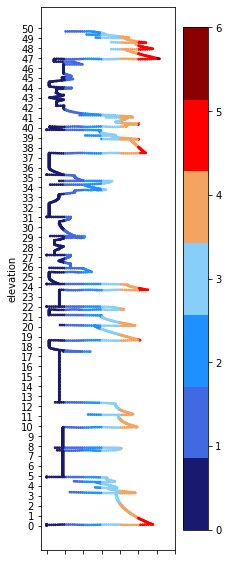

In [25]:
cmap = colors.ListedColormap(['midnightblue', 'royalblue',
                              'dodgerblue', 'lightskyblue', 
                              'sandybrown', 'red', 'darkred'])

df.plot.scatter(x='grainsize', y='elevation', c=facies,
                colormap=cmap, s=3, xticks=range(0,8), yticks=range(0,51), figsize=(3,10))

Let's create a `well` `Curve` to work with the data and turn into a `Striplog`

In [26]:
import welly
welly.__version__

'0.4.7'

In [27]:
from welly import Curve

In [28]:
w = welly.Well()

Add the parameters from the field data to create the well

In [29]:
params = {'header':{'Name':'Cairn'}, 'location':{}, 'mnemonic': 'Cairn',
         'service_company': 'brian', 'date': 'PhD', 'run': '2'}
params['location'] = {'Easting_x': 723290.82, 'Northing_y':4653815.56} 

In [30]:
h = welly.Header(params['header'])
l = welly.Location(params['location'])

In [31]:
w = welly.Well({'header': h, 'location': l})
w

Well(uwi: '', 0 curves: [])

We need to get the Z values 

In [32]:
z

array([4.9683e+01, 4.9683e+01, 4.9683e+01, ..., 6.7000e-02, 2.8000e-02,
       0.0000e+00])

Give the well the top and bottom that's required so it knows where it is. 
Also estimae the number of samples based on the Z values

In [33]:
top = np.min(z)
bottom = np.max(z)
nsamples = len(z)
top

0.0

Flip the z axis since `welly` works in **positive** depth, outcrops are in elevation

In [35]:
top_f = np.max(z)
bottom_f = np.min(z)
nsamples = len(z)
top_f

49.683

Make a new well basis - we want the thickness of the log not using the samples as the 'depth'

In [36]:
depth_basis = np.linspace(top, bottom, nsamples)
depth_basis

array([0.00000000e+00, 1.49602529e-02, 2.99205059e-02, ...,
       4.96530795e+01, 4.96680397e+01, 4.96830000e+01])

Creat a new `Welly` `Curve` for the log

In [37]:
cairn = Curve(gz, basis=depth_basis, params=params)
cairn

Curve([1.845, 2.19 , 1.5  , ..., 4.758, 0.   , 0.   ])

Quick plot to check what the curve looks like


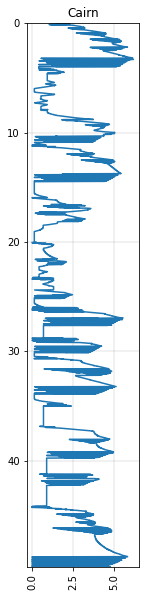

In [38]:
cairn.plot()

This kind of works, but the erosive bases in the log aren't right

We have the give our new `Welly` well affectionately called `Cairn` a basis

In [131]:
cairn.basis

array([0.00000000e+00, 1.49602529e-02, 2.99205059e-02, ...,
       4.96530795e+01, 4.96680397e+01, 4.96830000e+01])

We need to add the `Curve` to the `Welly` `well`

In [39]:
w.data['cairn'] = cairn

Now check that we've added the curve

In [40]:
w.data['cairn']

Curve([1.845, 2.19 , 1.5  , ..., 4.758, 0.   , 0.   ])

Let's do a quick plot of the Well

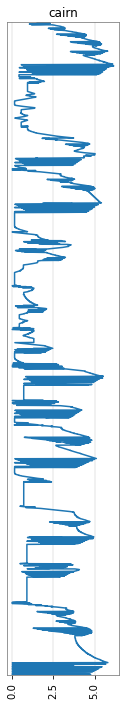

In [41]:
tracks = ['cairn']
w.plot(tracks=tracks)

#### Below is a way to parse the grain size from the 'depth' axis to get the facies 
This is so we can visualised the grainsize difference

Create 1D arrays from the discretised sedimentary log data

We're going to create a well for these curves

In [42]:
comps = [Component({'lithology': 'claystone'}),
         Component({'lithology': 'siltstone'}),
         Component({'lithology': 'vf_sandstone'}),
         Component({'lithology': 'f_sandstone'}),
         Component({'lithology': 'm_sandstone'}),
         Component({'lithology': 'c_sandstone'}),
         Component({'lithology': 'vc_sandstone'}),
        ]
comps

[Component({'lithology': 'claystone'}),
 Component({'lithology': 'siltstone'}),
 Component({'lithology': 'vf_sandstone'}),
 Component({'lithology': 'f_sandstone'}),
 Component({'lithology': 'm_sandstone'}),
 Component({'lithology': 'c_sandstone'}),
 Component({'lithology': 'vc_sandstone'})]

In [44]:
legend_csv = """comp lithology, colour, width
                claystone, #a2cffe, 0.5,
                siltstone, #448ee4, 1,
                vf_sandstone, #fdaa48, 1.5,
                f_sandstone, #fdaa48, 1.6,
                m_sandstone, #fdaa48, 1.65,
                c_sandstone, #fdaa48, 1.70,
                vc_sandstone, #fdaa48, 1.75"""
type(legend_csv)
legend = Legend.from_csv(text=legend_csv)

Create cutoffs for the different facies types 

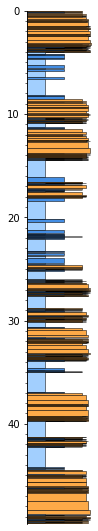

In [45]:
s = Striplog.from_log(cairn, cutoff=[1, 2, 3, 4, 5, 6], components=comps, basis=cairn.basis)
s.plot(lw=0.5, legend=legend, aspect=5)

#### Below are some ways to clean up the logs. You can find more about this in Agile's post [here](https://agilescientific.com/blog/2019/9/6/superpowers-for-striplogs)

#### You can also check out the notebooks [here](https://github.com/agile-geoscience/striplog/blob/master/tutorial/Binary_morphologies.ipynb) for a bit more description of it. 

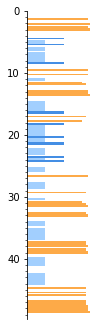

In [46]:
pruned = s.prune(limit=0.2, keep_ends=True)
pruned.plot(aspect=3, legend=legend)

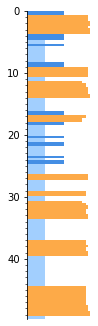

In [47]:
annealed = pruned.anneal()
annealed.plot(aspect=3, legend=legend)

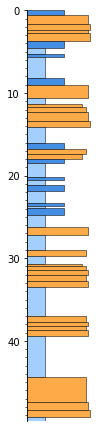

In [48]:
merged = annealed.merge_neighbours()
merged.plot(aspect=4, legend=legend, lw=.5)

Plot all of the logs we've cleaned up to see what we've done

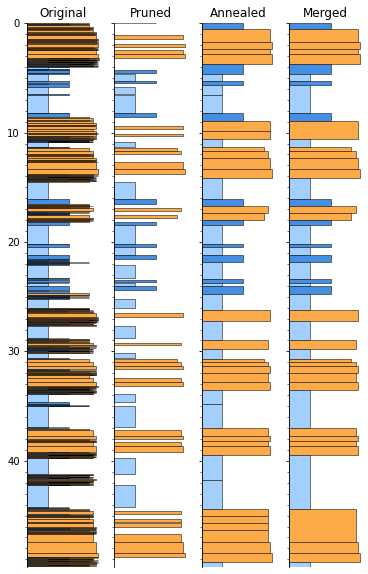

In [49]:
fig, axs = plt.subplots(ncols=4, figsize=(6, 10))

axs[0] = s.plot(legend=legend, ax=axs[0], lw=0.5, aspect=3)
axs[0].set_title('Original')
axs[1] = pruned.plot(legend=legend, ax=axs[1], lw=0.5, aspect=3)
axs[1].set_yticklabels([])
axs[1].set_title('Pruned')
axs[2] = annealed.plot(legend=legend, ax=axs[2], lw=0.5, aspect=3)
axs[2].set_yticklabels([])
axs[2].set_title('Annealed')
axs[3] = merged.plot(legend=legend, ax=axs[3], lw=0.5, aspect=3)
axs[3].set_yticklabels([])
axs[3].set_title('Merged')
plt.show()

#### Now we're going to make a `las` file from our log

Check what deatails we have from our `striplog`

In [51]:
merged.extract(cairn, basis=cairn.basis, name='grainsize', function=np.mean)
merged

Striplog(49 Intervals, start=0.0, stop=49.683)

In [52]:
merged[1]

Interval({'top': Position({'middle': 0.5684896115627823, 'units': 'm'}), 'base': Position({'middle': 1.6905085817524843, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'lithology': 'm_sandstone'})]})

We're going to make a welly log from the striplog

In [53]:
liths, lbasis, _ = merged.to_log(legend=legend, return_meta=True)
grainsize = merged.to_log(basis=lbasis, legend=legend, legend_field='width')

Let's check out the sample interval

In [54]:
lbasis[1]-lbasis[0]

0.99366

Make a dictionary of parameters of the things we want to associated wit hte curve in the lasfile

In [55]:
litho_params = {'description': 'Cairn Lithology',
               'mnemonic': 'Lith'
               }
grain_params = {'description': 'Cairn Grainsize',
               'mnemonic': 'grsz'
               }

Pass the `ndarrays` and the parameters `dicts` to the `Curve` method

In [56]:
lithCurve = Curve(liths, lbasis, litho_params)
grainCurve = Curve(grainsize, lbasis, grain_params)

Add the new curves to the  collection of curves that already exist in `w.data`(another dictionary)

In [57]:
w.data['cairn_striplog'] = merged
w.data['cairn_grsz'] = grainCurve
w.data['cairn_lith'] = lithCurve

Create a `Legend` for the `Cruves`

In [59]:
curve_legend_csv = """color, lw, xcale, curve mnemonic
                      #a57fe8, 1.5, linear, cairn_lith,
                      #2c6fbb, 1.0, linear, cairn"""
curve_legend_csv



'color, lw, xcale, curve mnemonic\n                      #a57fe8, 1.5, linear, cairn_lith,\n                      #2c6fbb, 1.0, linear, cairn'

In [60]:
curve_legend = Legend.from_csv(text=curve_legend_csv)
curve_legend

colour,xcale,lw,hatch,width,curve
#a57fe8,linear,1.5,None,None,{'mnemonic': 'cairn_lith'}
#2c6fbb,linear,1.0,None,None,{'mnemonic': 'cairn'}


In [61]:
legend_c = legend + curve_legend

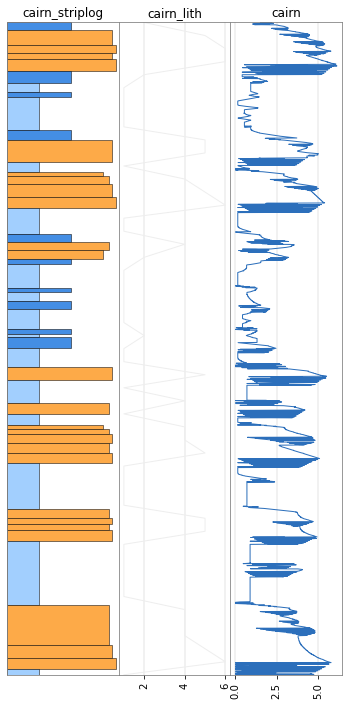

In [62]:
tracks = ['cairn_striplog', 'cairn_lith', 'cairn']
w.plot(tracks=tracks, legend=legend_c, basis=cairn.basis, lw=0.5)

We need to write these curves (`lith, grnsz, Striplog`) by passing a list of mnemonics we want in the output file, to the `well.to_las()` method

In [63]:
keys = ['cairn_lith']

In [64]:
w.to_las('outcrop_grainsize_2_well.LAS', keys=keys)

Now let's add a striplog to the well and export. This will put the `striplog` stuff in the `~other` section of the LAS file, where as the `Curve` data is in the `~Ascii` section.

In [65]:
w.data['cairn_striplog'] = merged

In [66]:
keys = ['cairn_lith', 'cairn_triplog']

In [67]:
w.to_las('lithology_and_Striplog.LAS')

Simple as that, we now have a `LAS` file from our sedimentary log.